In [1]:
import pandas as pd

In [33]:
sample = None

product = ['code', 'countries','url', 'product_name', 'brands', 'categories_en']

nutrient = ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g', 'polyols_100g', 'alcohol_100g']

columns_to_load = product + nutrient

opf_data = pd.read_csv('/Users/baslad01/data_dump/openfoodfacts/product_data/en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8', on_bad_lines='skip', nrows=sample,
                       usecols=columns_to_load)
opf_data.head()

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_42280/2320493923.py:9: DtypeWarning: Columns (0,89,91) have mixed types. Specify dtype option on import or set low_memory=False.
  opf_data = pd.read_csv('/Users/baslad01/data_dump/openfoodfacts/product_data/en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8', on_bad_lines='skip', nrows=sample,


,code,url,product_name,brands,categories_en,countries,energy_100g,fat_100g,carbohydrates_100g,polyols_100g,fiber_100g,proteins_100g,alcohol_100g
0,54,http://world-en.openfoodfacts.org/product/0000...,Limonade artisanale a la rose,NaN,NaN,en:fr,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-en.openfoodfacts.org/product/0000...,Tablette Tanzanie,NaN,NaN,en:fr,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,http://world-en.openfoodfacts.org/product/0000...,CORDYCEPS,Cordyceps Sinensis,"Dietary supplements,Vitamins","Allemagne, États-Unis, en:fr",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,http://world-en.openfoodfacts.org/product/0000...,NaN,Curiositea House,it:olio-di-mandorle-dolci,Estados Unidos,293.0,4.0,3.00,NaN,NaN,1.00,NaN
4,3,http://world-en.openfoodfacts.org/product/0000...,Javvy protein coffee,Javvy,"Protein,Smoked-meat","Griechenland, Germany",816.0,10.73,14.63,NaN,0.98,0.51,NaN


In [56]:
# Remove the rows where the energy is missing
opf_data = opf_data[opf_data['energy_100g'].notna()]
# Remove energy if not float or int
opf_data = opf_data[opf_data['energy_100g'].apply(lambda x: isinstance(x, (int, float)))]
# Replace Nan with zeros on the nutrient columns
nutrient.remove('energy_100g')
for col in nutrient:
    opf_data[col] = opf_data[col].fillna(0)
opf_data.head()

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_42280/1021640764.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  opf_data[col] = opf_data[col].fillna(0)


,code,url,product_name,brands,categories_en,countries,energy_100g,fat_100g,carbohydrates_100g,polyols_100g,fiber_100g,proteins_100g,alcohol_100g
3,2,http://world-en.openfoodfacts.org/product/0000...,NaN,Curiositea House,it:olio-di-mandorle-dolci,Estados Unidos,293.0,4.00,3.00,0.0,0.00,1.00,0.0
4,3,http://world-en.openfoodfacts.org/product/0000...,Javvy protein coffee,Javvy,"Protein,Smoked-meat","Griechenland, Germany",816.0,10.73,14.63,0.0,0.98,0.51,0.0
5,4,http://world-en.openfoodfacts.org/product/0000...,Energy+ Focus,TruLabs,Sample,Německo,21800.0,0.00,18.20,0.0,0.00,0.00,0.0
6,5,http://world-en.openfoodfacts.org/product/0000...,Artikel 1,"EWL, bla","Plant-based foods and beverages,Plant-based fo...","Frankreich, Germany",840.0,0.00,8.00,0.0,88.00,0.00,0.0
8,7,http://world-en.openfoodfacts.org/product/0000...,Allumettes de bacon,Le marsigny,Butfalo-mac-and-cheese,en:Spain,519.0,5.00,0.80,0.0,0.00,19.00,0.0


In [57]:
# Create a linear regression model to predict the energy value given all the other nutrients in the product marked by _100g
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Filter the columns that have _100g in them
opf_num_features = opf_data.filter(regex='_100g')

# Convert all columns to float, setting errors='coerce' to convert non-convertible values to NaN
opf_num_features = opf_num_features.apply(pd.to_numeric, errors='coerce')

# Replace Nan with zeros
opf_num_features.fillna(0, inplace=True)

opf_num_features = opf_num_features.astype('float64')

In [58]:
# Remove the rows where the nutrient are above 100g
for col in nutrient:
    if col == 'energy_100g':
        continue
    opf_num_features = opf_num_features[opf_num_features[col] <= 100]


In [59]:
# Remove the rows where the energy is above 3700 (theoretical maximum)
opf_num_features = opf_num_features[opf_num_features['energy_100g'] <= 3700]

In [60]:
# Remove the row when all the nutrients are zero and energy is not zero
opf_num_features = opf_num_features[(opf_num_features[nutrient].sum(axis=1) > 0) | (opf_num_features['energy_100g'] == 0)]

In [61]:
# Cap outliers for all the features
for col in opf_num_features.columns:
    q1 = opf_num_features[col].quantile(0.25)
    q3 = opf_num_features[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    opf_num_features[col] = opf_num_features[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(opf_num_features.drop(columns=['energy_100g']), opf_num_features['energy_100g'], test_size=0.2, random_state=42)

# Create the model
model = LinearRegression(fit_intercept=False)

# Fit the model
model.fit(X_train, y_train)

# Predict the energy value
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

78178.04211372402

In [62]:
# Get the coefficients of the model
coefficients = model.coef_

# Get the intercept of the model
intercept = model.intercept_

# Print the formula with the intercept
formula = f'{round(intercept, 2)} + '
for i, col in enumerate(X_train.columns):
    formula += f'{round(coefficients[i], 2)} * {col} + '
# Remove the last ' + ' from the formula
formula = formula[:-3]

print(f'Linear Regression Formula: {formula}')

Linear Regression Formula: 0.0 + 41.6 * fat_100g + 15.7 * carbohydrates_100g + -0.0 * polyols_100g + 2.02 * fiber_100g + 16.92 * proteins_100g + 0.0 * alcohol_100g


## The theorethical model should be:

According to this link: https://mirabelle.openfoodfacts.org/products/energy_calculator

calories = 37 * fat + 17 * proteins + 29 * alcohol + 17 * (carbohydrates - polyols) + 10 * polyols + 8 * fiber

In [83]:
# Get the top item when the theorethical model is close to the predicted model

opf_num_features_delta = opf_num_features.copy()

opf_num_features_delta = opf_num_features_delta[opf_num_features_delta['energy_100g'] > 0]

opf_num_features_delta['predicted_energy'] = model.predict(opf_num_features_delta.drop(columns=['energy_100g']))
opf_num_features_delta['predicted_energy'] = opf_num_features_delta['predicted_energy'].apply(lambda x: round(x, 2))

opf_num_features_delta['theorethical_energy'] = 37 * opf_num_features_delta['fat_100g'] + 17 * opf_num_features_delta['proteins_100g'] + 29 * opf_num_features_delta['alcohol_100g'] + 17 * (opf_num_features_delta['carbohydrates_100g'] - opf_num_features_delta['polyols_100g']) + 10 * opf_num_features_delta['polyols_100g'] + 8 * opf_num_features_delta['fiber_100g']
opf_num_features_delta['theorethical_energy'] = opf_num_features_delta['theorethical_energy'].apply(lambda x: round(x, 2))

# Remove rows where the theorethical energy is zero
opf_num_features_delta = opf_num_features_delta[opf_num_features_delta['theorethical_energy'] > 0]

# opf_num_features_delta['diff'] = abs(opf_num_features_delta['predicted_energy'] - opf_num_features_delta['theorethical_energy'])

opf_num_features_delta['diff'] = opf_num_features_delta['theorethical_energy'] - opf_num_features_delta['predicted_energy']
opf_num_features_delta['diff_actual'] = opf_num_features_delta['theorethical_energy'] - opf_num_features_delta['energy_100g']
opf_num_features_delta.sort_values(by='diff', ascending=True, inplace=True)


In [81]:
# Add the product_name to the dataframe
# opf_data.set_index('code', inplace=True)
opf_data_add = opf_data.loc[opf_num_features_delta.index]

opf_num_features_delta = pd.concat([opf_data_add, opf_num_features_delta], axis=1)
opf_num_features_delta.head()

,code,url,product_name,brands,categories_en,countries,energy_100g,fat_100g,carbohydrates_100g,polyols_100g,...,fat_100g,carbohydrates_100g,polyols_100g,fiber_100g,proteins_100g,alcohol_100g,predicted_energy,theorethical_energy,diff,diff_actual
2417161,5410093152633,http://world-en.openfoodfacts.org/product/5410...,Huile d’arachide,Vandemoortele,Fats,"France, en:belgium",3464.0,92.0,0.001,0.0,...,49.75,0.001,0.0,0.0,0.001,0.0,2069.48,1840.78,-228.7,1620.72
1368394,3217450004534,http://world-en.openfoodfacts.org/product/3217...,Ail & Romarin,Jardin Bio,NaN,France,3439.0,91.0,0.001,0.0,...,49.75,0.001,0.0,0.0,0.001,0.0,2069.48,1840.78,-228.7,1598.22
1530602,3368321053387,http://world-en.openfoodfacts.org/product/3368...,St Hubert omega 3,NaN,NaN,en:fr,1958.0,52.0,0.001,0.0,...,49.75,0.001,0.0,0.0,0.001,0.0,2069.48,1840.78,-228.7,117.22
2524382,5906245444300,http://world-en.openfoodfacts.org/product/5906...,Olej z nasion czarnuszki,NaN,NaN,France,3201.0,85.0,0.001,0.0,...,49.75,0.001,0.0,0.0,0.001,0.0,2069.48,1840.78,-228.7,1360.22
2361034,5200102951049,http://world-en.openfoodfacts.org/product/5200...,Huile olive,NaN,NaN,France,3448.0,100.0,0.001,0.0,...,49.75,0.001,0.0,0.0,0.001,0.0,2069.48,1840.78,-228.7,1607.22


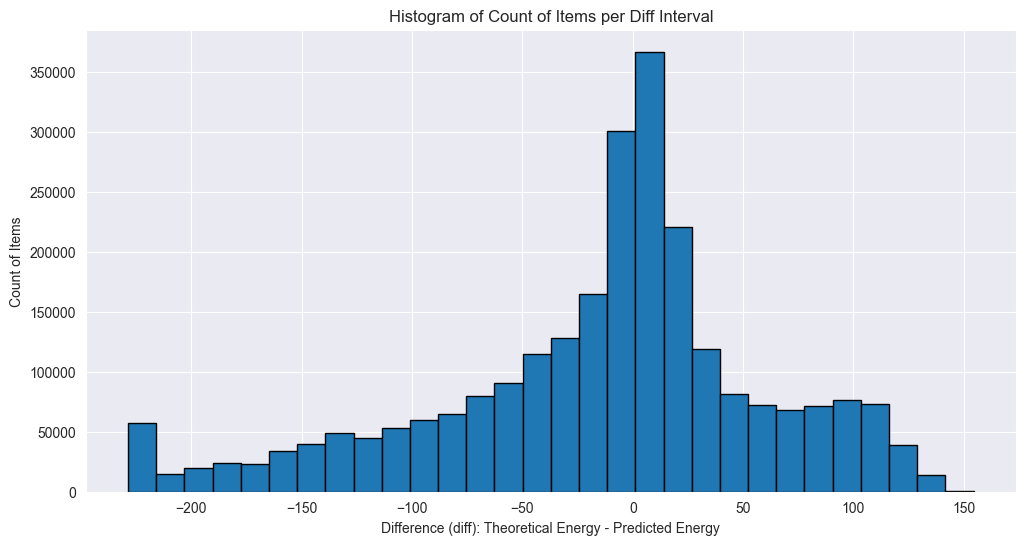

In [84]:
# Plot the difference between the predicted and the theorethical energy values
import matplotlib.pyplot as plt

# Plot the histogram of the 'diff' column
plt.figure(figsize=(12, 6))
plt.hist(opf_num_features_delta['diff'], bins=30, edgecolor='black')
plt.xlabel('Difference (diff): Theoretical Energy - Predicted Energy')
plt.ylabel('Count of Items')
plt.title('Histogram of Count of Items per Diff Interval')
plt.show()

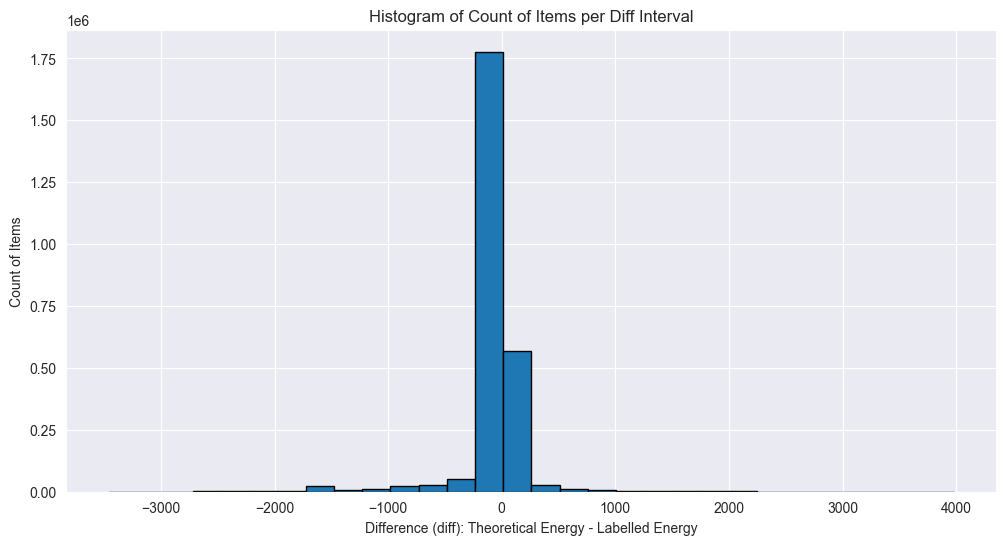

In [85]:
import matplotlib.pyplot as plt

# Plot the histogram of the 'diff' column
plt.figure(figsize=(12, 6))
plt.hist(opf_num_features_delta['diff_actual'], bins=30, edgecolor='black')
plt.xlabel('Difference (diff): Theoretical Energy - Labelled Energy')
plt.ylabel('Count of Items')
plt.title('Histogram of Count of Items per Diff Interval')
plt.show()